## Installs and dependencies

In [2]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.36 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


In [3]:
from unityagents import UnityEnvironment
import numpy as np

import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from unityagents import UnityEnvironment
from ddpg_agent import Agent

## Instantiate environnement and agents

In [4]:
# load version 2 of the environment (with 20 agents)
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# get problem sizes
state_size = brain.vector_observation_space_size
action_size = brain.vector_action_space_size

In [6]:
# create a new agent
agent = Agent(state_size=state_size, action_size=action_size, n_agents=20, random_seed=17)

### Training with DDPG

In [7]:
def ddpg(n_episodes=10000, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations  # get the current states
        parallel_scores = np.zeros(20)  # for each of the 20 agents
        agent.reset()
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]      
            rewards = env_info.rewards                    
            next_states = env_info.vector_observations   
            dones = env_info.local_done               
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            parallel_scores += rewards
            if np.any(dones):
                break 
        mean_score = np.mean(parallel_scores)
        scores_deque.append(mean_score)
        scores.append(mean_score)
        torch.save(agent.actor_local.state_dict(), 'weights/checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'weights/checkpoint_critic.pth')
        print('\rEpisode {:d}\tscore: {:.2f}\taverage score over the last 10 episodes: {:.2f}'.format(i_episode, scores_deque[-1], np.mean(list(scores_deque)[-10:])), end="")
        #if i_episode % 10 == 0:
        #    torch.save(agent.actor_local.state_dict(), 'weights/checkpoint_actor_{:d}_{:.2f}.pth'.format(i_episode, scores_deque[-1]))
        #    torch.save(agent.critic_local.state_dict(), 'weights/checkpoint_critic_{:d}_{:.2f}.pth'.format(i_episode, scores_deque[-1]))
        if i_episode > 100 and np.mean(scores_deque) > 30:
            torch.save(agent.actor_local.state_dict(), 'weights/checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'weights/checkpoint_critic.pth')
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores

In [8]:
scores = ddpg()

Episode 100	Average Score: 27.43 score over the last 10 episodes: 37.12
Episode 108	score: 37.32	average score over the last 10 episodes: 37.23
Environment solved in 8 episodes!	Average Score: 30.32


In [ ]:
env.close()

## Print results

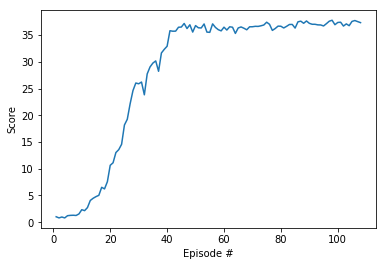

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()